In [1]:
# This notebook allows visualization of the downstream/upstream/recurrence proportionality in number of connections, or number
# of synapses for the pt_root_ids of interest in stacked bar charts or in percent stacked bar charts.

In [2]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from IPython.core.debugger import set_trace
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import networkx as nx
pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [3]:
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

# List of Functions to be used (not all)
i.e. get_count_connections, 

In [20]:
# for partner in partners
    # if partner has postsynaptic partner as tactile or gustatory
        # partner is upstream of tactile or gustatory
    # if partner has presynaptic partner as tactile or gustatory
        # partner is downstream of tactile or gustatory
    # if partner is both postsynaptic and presynaptic of tactile or gustatory
        # partner is recurrent of tactile or gustatory
def check_partners(dwn_lst, up_lst,partner_lst):
    dct = {partner_lst[i]: 'None' for i in range(0, len(partner_lst))}
    for partner in dct:
        # check dwn_lst
        # if pt_root_id of partner is in dwn_lst --> downstream partner
        if partner in dwn_lst:
            dct[partner] = 'downstream'
        # check up_df
        # if pt_root_id of partner is in up_lst --> upstream partner
        if partner in up_lst:
            dct[partner] = 'upstream'
        # check both
        # if pt_root_id of partner is in both --> recurrent
        if partner in dwn_lst and partner in up_lst:
            dct[partner] = 'recurrent' 
    return dct  

# get partners ids (down/up) of the given list of pt_root_ids
def check_partners_individual(pt_root_ids, queried_ids = 'bristle_pt_root_id'):
    # query for upstream and downstream partners
    upstream_table = client.materialize.synapse_query(post_ids=pt_root_ids)
    downstream_table = client.materialize.synapse_query(pre_ids=pt_root_ids)
    
    # get uplist through obtaining pre_pt_root_id of its table and dwnlist through post_pt_root_id of its table
    uplist = upstream_table['pre_pt_root_id'].unique()
    downlist = downstream_table['post_pt_root_id'].unique()
    
    # append another column of bristle and partner pt_root_id
    upstream_table['partner_pt_root_id'] = upstream_table['pre_pt_root_id']
    upstream_table[queried_ids] = upstream_table['post_pt_root_id']
    downstream_table['partner_pt_root_id'] = downstream_table['post_pt_root_id']
    downstream_table[queried_ids] = downstream_table['pre_pt_root_id']
    
    # concat the tables
    df = pd.concat([upstream_table, downstream_table], axis=0)
    # concat up and dwn list for partner list
    partner_lst = [*set(np.concatenate([uplist,downlist], axis=0))]
    
    # use check_partners to obtain mapping dct for each partner
    dct = check_partners(downlist, uplist, partner_lst=partner_lst)
    
    # map each partner to the mapping dct
    df['label'] = df['partner_pt_root_id'].map(dct)
    return df

# Gets order as a list by cosine similarity
# sim_mat is a matrix of cosine_similarity(conn_mat) where conn_mat is a pre by post np.array
# of the number of connections between pre and post_pt_root_id
def get_clustered_order(sim_mat, distance_threshold = 0, 
                       n_clusters = None, **kwargs):
    
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None).fit(sim_mat)
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    parsed_order = []
    for c in clustered_order:
        if '(' in c:
            c = c.split('(')[1]
            c = c.split(')')[0]
        parsed_order.append(int(c))
    
    return parsed_order

# choice=1 for downstream connection order, choice=2 for upstream connection order
# edges are required to know which directionality you want the pt_root_ids to be arranged by
# df_edges is the total df_edges that has label of 'upstream/downstream/recurrent' coresponding to the partners
# bins are the number of pt_root_ids
# hue are the labels with which the proportionality is drawn for
# title is the title of the produced bar graph
def sns_hist_cos_sim(edges, df_edges, hue='label', choice=1, title="Types of Connectivity",
                    x_label="Bristle Axon", y_label="Number of Connections", bins=140):
    df_edges, bins = get_orders_for_df(edges, df_edges, hue=hue, choice=choice)
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)

    sns.histplot(data=df_edges, ax=ax, multiple="stack",
                 x="order", bins = bins,
                 palette="Paired", hue=hue, 
                 element="bars", legend=True)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label) # number of partners connected to
    sns.move_legend(ax, "upper right",frameon=False,bbox_to_anchor=(1.1, 1))
    #plt.savefig('../Bristle_project/figures/celltype_downstream_input_conn.png')
    return df_edges

def get_orders_for_df(edges, df_edges, queried_ids):
    edges = edges

    # pre and post pt_root_ids list
#     if choice == 1:
    pre = edges.pre_pt_root_id.unique().tolist()
    post = edges.post_pt_root_id.unique().tolist()
#     else:
#         post = edges.pre_pt_root_id.unique().tolist()
#         pre = edges.post_pt_root_id.unique().tolist()

    # initialize conn_mat with length of pre and post pt_root_ids
    conn_mat = np.zeros((len(pre),len(post)))
    print(conn_mat.shape)

    # enumerate every pre_pt_root_id in pre list
    for ix, i in enumerate(pre):
        # locates rows with pre_pt_root_id as such
        subset = edges[edges.pre_pt_root_id == i]

        for jx, j in enumerate(post):
            if j in subset.post_pt_root_id.tolist():
                c = subset[subset.post_pt_root_id==j]['count'].tolist()[0]
                conn_mat[ix,jx] = c
    sim_mat = cosine_similarity(conn_mat)
    clustered_order = get_clustered_order(sim_mat)
    ids_ordered = [pre[i] for i in clustered_order]
    id_dict = dict(zip(ids_ordered,[i for i in range(len(clustered_order))]))

    df_edges['order'] = df_edges[queried_ids].map(id_dict)

#     order = []
#     df_edges= df_edges
#     for i in df_edges[queried_ids]:
#         ix = 140
#         for jx, j in enumerate(id_dict):
#             if i == j:
#                 ix = jx

#         order.append(ix)
#     df_edges['order'] = order
    return df_edges

# tot_df is of order and count column only and comprises ALL the counts
# label_df is of order and count column only and comprises parts of counts
def get_full_axon_df(tot_df, label_df):
    lst = [i for i in range(tot_df.shape[0])]
    dct2 = dict(zip(label_df['order'], label_df['count']))
    dct1 = {lst[i]: 0 for i in range(len(lst))}
    dct1.update(dct2)
    keys = list(dct1.keys())
    vals = list(dct1.values())
    new_dct = {'order':keys, 'count':vals}
    df = pd.DataFrame(data=new_dct)
    return df

# lst should always be a list of string of the column labels, and the first 4 elements of the list must
# be ['pre_pt_root_id', 'post_pt_root_id','partner_pt_root_id', 'interested_pt_root_ids']. Must also include 'label' of
# upstream/downstream/recurrent if wanting to visualize the proportionality for them. Else, can include a hue/hues of choice.
# num_thresh is the minimum number of connections to be included in the df_edges 
def get_edges(df, lst, num_thresh=3):
    df_edges = df.groupby(lst).size().sort_values(ascending=False).reset_index(name='count')
    df_edges = df_edges.query(f'count > {num_thresh}')
    return df_edges


# gets the count through performing groupby(['column_interested', 'classification_interested'])
def get_count_connections(df, lst):
    df_edges = df.groupby(lst).size().sort_values(ascending=False).reset_index(name='count')

# get counts of synapses of the df given (assuming df has column of count of synapses for each pt_root_id pair of interest)
# column: the column label of interest to be filtered
# tot: the groupby total of the df's counts of synapses
# test: the classification of the group of interested rows that we want to query for
# groupby: the classification of interest we want to assign the counts to
def get_count_synapse(df, tot, test='upstream', groupby='order'):
    up = df[df['label']==test].groupby(groupby)['count'].sum().reset_index()
    up = get_full_axon_df(tot, up)
    return up
    
def get_count_by_proportionality(df, df_groupby_total, label):
    df_portion = get_count_synapse(df, df_groupby_total, test=label)
    df_portion['count'] = [i / j * 100 for i,j in zip(df_portion['count'], df_groupby_total['count'])]
    df_portion.name = label;
    return df_portion

# def get_total_counts_by_order(df_edges):
#     return df_edges.groupby(['order'])['count'].sum().reset_index()

def plot_percent_stacked_bar(total, args, queried_ids, x='order', only=[]):
    f = plt.figure(figsize=(30,10))
    ax = f.add_subplot(1,1,1)
    bottom = [0 for i in range(total.shape[0])]
    if len(only) != 0:
        for arg in args:
            if arg.name in only:
                ax.bar(arg[x], arg['count'], bottom=bottom, edgecolor='white', label=arg.name)
                bottom = [i+j for i,j in zip(bottom, arg['count'])]
            else:    
                ax.bar(arg[x], arg['count'], color='#808080', bottom=bottom, edgecolor='white')
                bottom = [i+j for i,j in zip(bottom, arg['count'])]
    else:
        for arg in args:
           ax.bar(arg[x], arg['count'], bottom=bottom, edgecolor='white', label=arg.name)
           bottom = [i+j for i,j in zip(bottom, arg['count'])]
    plt.legend(loc='lower right', bbox_to_anchor=(1,1), ncol=1, prop={"size":20})
    ax.set_title('Connection Directionality')
    ax.set_xlabel(queried_ids)
    ax.set_ylabel("Synapses by Percentage per pt_root_id")

In [5]:
# pt_root_ids(list/tuple): interested point root ids to examine the flow of information (downstream/upstream/recurrent)
# queried_ids(str): the name of the pt_root_ids' classification of interest.
# num_thresh(int): the minimum number of connections between the interested ids and their partners to be included
# only: the list of labels (downstream/upstream/recurrent) that should be visualized. Defaulted to empty list --> color everything
def plot_percent_stacked_bar_by_synapse(pt_root_ids, queried_ids, num_thresh=3, only=[]):
    pt_root_ids = [*set(pt_root_ids)]
    df = check_partners_individual(pt_root_ids[0], queried_ids=queried_ids)
    pt_root_ids.pop(0)
    for pt_root_id in pt_root_ids:
        df1 = check_partners_individual(pt_root_id, queried_ids=queried_ids)
        # concat the current bristle dataframe with the just made bristle dataframe
        df = pd.concat([df, df1], axis=0)
    edges = get_edges(df, ['pre_pt_root_id', 'post_pt_root_id', 'partner_pt_root_id', 
                           queried_ids, 'label'], num_thresh=num_thresh)
    downstream_edges = edges.loc[(edges[queried_ids] == edges.pre_pt_root_id)]
    edges = get_orders_for_df(downstream_edges, edges, queried_ids)

    total = edges.groupby(['order'])['count'].sum().reset_index()
    subdf_lst = []
    for label in [*df.label.unique()]:
        subdf_lst.append(get_count_by_proportionality(edges, total, label))
    plot_percent_stacked_bar(total, subdf_lst, queried_ids, only=only)

In [6]:
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

### Speicfy the pt_root_ids interested for analysis of directionality

In [7]:
bristle_df= client.materialize.query_table('bristle_axon_table')
leg_df = bristle_df[bristle_df.classification_system=='T1_L']
bristle_ids = leg_df['pt_root_id'].tolist() # stores interested pt_root_ids as a list here

In [8]:
# makes a copy of the list of pt_root_ids
pt_root_ids = bristle_ids.copy()

### Finds and returns directionality in the table 
uses check_partners_individual(pt_root_id_interested, queried_ids="pt_root_ids_population_name") on every pt_root_id to find all the partners and their directionality in relation to the pt_root_ids. (New column name with such information is recorded as "label.")

In [14]:
pt_root_ids = [*set(pt_root_ids)]
df = check_partners_individual(pt_root_ids[0], queried_ids="interested_pt_root_ids")
pt_root_ids.pop(0)
for pt_root_id in pt_root_ids:
    df1 = check_partners_individual(pt_root_id, queried_ids="interested_pt_root_ids")
    # concat the current bristle dataframe with the just made bristle dataframe
    df = pd.concat([df, df1], axis=0)

### Gets synapse counts of each pre and post relation 
uses get_edges(df_just_made, [group_by_column], num_thresh=3) to get the synapse counts between the pre and post by specifying the df to get the synapse counts of and the minimum number of synapse counts there must be for each connection between two pt_root_ids to be included in the table

In [15]:
edges = get_edges(df, ['pre_pt_root_id', 'post_pt_root_id', 'partner_pt_root_id', 
                           "interested_pt_root_ids", 'label'], num_thresh=3)

### Order the interested pt_root_ids by similarity
We can have the interested pt_root_ids that are more similar (in terms of downstream connectivity) to one another grouped together by calling the function get_orders_for_df. The function's syntax is get_orders_for_df(downstream_edges, edges, queried_ids) where:

    - downstream_edges is the extracted rows with pre_pt_root_ids being the interested pt_root_ids
    - edges is current master df with information on pre_pt_root_ids, post_pt_root_ids, interested_pt_root_ids, 
      partners_pt_root_ids (obtained through get_edges previously)
    - queried_ids: the name of the population of interested_pt_root_ids (for graphing/naming purposes)
    

(139, 1189)


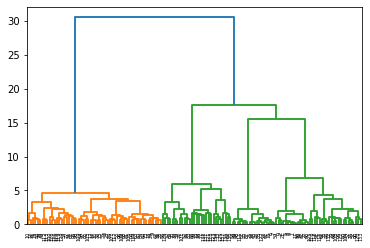

In [16]:
downstream_edges = edges.loc[(edges["interested_pt_root_ids"] == edges.pre_pt_root_id)]

# updating the master df with a new column for "order"

edges = get_orders_for_df(downstream_edges, edges, "interested_pt_root_ids")

### Plotting percent stacked bar charts by the proportionality of each interested_pt_root_id connection's directionality to partners
We now have the counts of synapses, the order the interested_pt_root_ids should be plotted in. In order to plot the percentage of each interested_pt_root_id connection's directionality to partners (i.e. the percentage of upstream/downstream/recurrent connection made by each interested_pt_root_id), the "count" column of the master df has to be updated so that it reflects the percentage of each directionality over the total. Then, we can use the plot_percent_stacked_bar(total, args, queried_ids, x='order', only=[]) function to plot the proportionality where:

    - total (df): the number of synapses of each interested_pt_root_id
    - args: the list of dfs with "counts" column updated. Each element is a df with only either 
      upstream/downstream/recurrent rows included.
    - queried_ids: the name of the population of the interested_pt_root_ids
    - x="order": the x-axis to be plotted (instead of long interested_pt_root_ids, use unique order to each 
      interested_pt_root_id instead.)
    - only=[]: list of names of directionality to be visualized. If only is empty, plot normally with all directionality 
      colored. If not empty, have the directionality not included greyed out and the directionalities included colored.

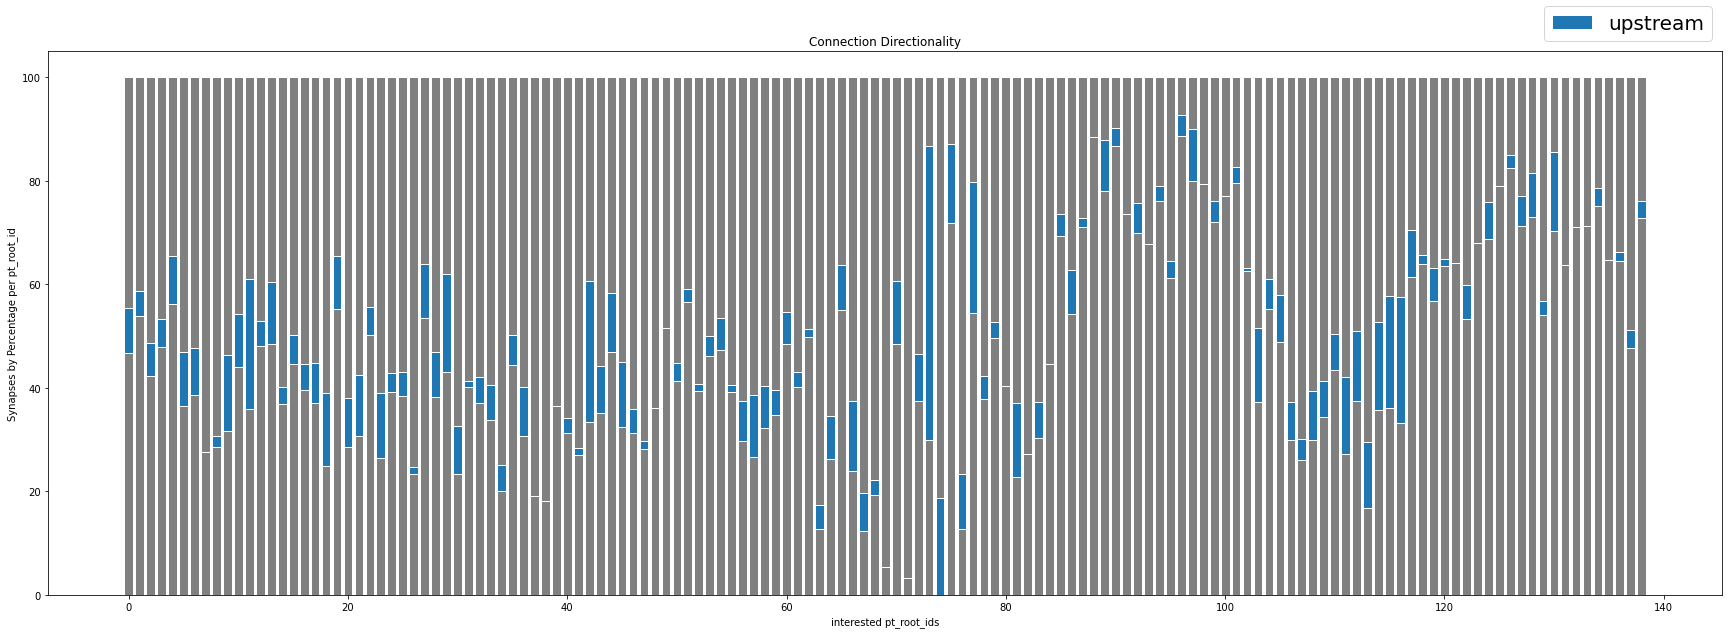

In [21]:
# obtain the total number of synapse counts for each dfs
total_df = edges.groupby(['order'])['count'].sum().reset_index()

# use get_count_by_proportionality to obtain each directionality's percentage over the total population
# get_count_proportionality(edges, total, label, column='label'):
    # edges: the master df that has all information on "count," "order," "directionality/label"
    # total_df: the df obtained previously to get the total number of synapse counts for each interested_pt_root_od
    # label: the label of each directionality
subdf_lst = []
for label in [*df.label.unique()]:
    subdf_lst.append(get_count_by_proportionality(edges, total_df, label))
    
# plots the percent stacked bar chart (only visualize upstream proportion)
plot_percent_stacked_bar(total_df, subdf_lst, 'interested pt_root_ids', only=['upstream'])

In [ ]:
plot_percent_stacked_bar_by_synapse(pt_root_ids,'Bristles', only=[])